# Student Depression Neural Network

## Table of Contents

- [Student Depression](#student-depression)
  - [Table of Contents](#table-of-contents)
- [Classes](#classes)
- [Load Data](#load-data)
- [Stratified Shuffle Split](#stratified-shuffle-split)
- [Encoding Maps](#encoding-maps)
- [Data Pipeline](#data-pipeline)
- [Neural Network](#neural-network)
  - [Import Libraries](#import-libraries)
  - [Train the Model](#train-the-model)
  - [Iteration 1](#iteration-1)
  - [Iteration 2](#iteration-2)
  - [Iteration 3](#iteration-3)
  - [Iteration 4](#iteration-4)
  - [Iteration 5](#iteration-5)



# Classes

In [322]:
import warnings
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('future.no_silent_downcasting', True)

class CustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mapping):
        self.mapping = mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, (pd.Series, pd.DataFrame)):
            raise ValueError("Input must be a pandas Series or DataFrame.")
        
        # If input is a Series, work directly
        if isinstance(X, pd.Series):
            X_transformed = X.replace(self.mapping)
            X_transformed = X_transformed.infer_objects(copy=False)  # Explicit call
            return X_transformed.values.reshape(-1, 1)
        
        # If input is a DataFrame, assume only one column is passed for transformation
        if X.shape[1] != 1:
            raise ValueError("DataFrame input must have exactly one column for this transformer.")
        
        column_name = X.columns[0]
        X_transformed = X[column_name].replace(self.mapping)
        X_transformed = X_transformed.infer_objects(copy=False)  # Explicit call
        return X_transformed.values.reshape(-1, 1)


In [323]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class AgeBinner(BaseEstimator, TransformerMixin):
    def __init__(self, bins=None, labels=None):
        self.bins = bins if bins else [0, 19, 24, 29, 34, 100]
        self.labels = labels if labels else ["Teenager (18-19)", "Young Adult (20-24)", 
                                             "Early Career (25-29)", "Mid-Career (30-34)", "Established (35+)"]

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        # Ensure X is a 1D array
        if isinstance(X, np.ndarray) and X.ndim > 1:
            X = X[:, 0]

        # Apply binning using pd.cut
        binned_ages = pd.cut(X, bins=self.bins, labels=self.labels, right=False)

        # Convert to a NumPy array and reshape to 2D for OneHotEncoder
        return np.array(binned_ages).reshape(-1, 1)  


# Load Data

In [324]:
import pandas as pd

file_path = r"/Users/valerian/Desktop/Jupyter/DT2/Student Depression Dataset.csv"
df = pd.read_csv(file_path)

# Define a dictionary to map old column names to new, shorter, lowercase names
column_mapping = {
    'id': 'id',
    'Gender': 'gender',
    'Age': 'age',
    'City': 'city',
    'Profession': 'prof',
    'Academic Pressure': 'acad_press',
    'Work Pressure': 'work_press',
    'CGPA': 'cgpa',
    'Study Satisfaction': 'study_sat',
    'Job Satisfaction': 'job_sat',
    'Sleep Duration': 'sleep_dur',
    'Dietary Habits': 'diet_habits',
    'Degree': 'degree',
    'Have you ever had suicidal thoughts ?': 'suicidal_thoughts',
    'Work/Study Hours': 'work_hours',
    'Financial Stress': 'fin_stress',
    'Family History of Mental Illness': 'fam_hist_mental',
    'Depression': 'depression'
}
# Remove extra spaces from all columns in the Data Frame
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

df.columns = df.columns.str.strip()  # Strips leading and trailing
initial_size = df.shape[0]
df.rename(columns=column_mapping, inplace=True)
df.head(4)

,id,gender,age,city,prof,acad_press,work_press,cgpa,study_sat,job_sat,sleep_dur,diet_habits,degree,suicidal_thoughts,work_hours,fin_stress,fam_hist_mental,depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1


# Stratified Shuffle Split

In [325]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the target variable
target_column = 'depression'

# Create a stratification column combining categorical features (excluding the target)
strat_columns = ['gender', 'suicidal_thoughts', 'fam_hist_mental']
df['stratify_column'] = df[strat_columns].astype(str).agg('_'.join, axis=1)

# Stratified Shuffle Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df['stratify_column']):
    train_set = df.iloc[train_index].copy()
    test_set = df.iloc[test_index].copy()

# Drop the stratification column
train_set.drop(columns=['stratify_column'], inplace=True)
test_set.drop(columns=['stratify_column'], inplace=True)

# Separate features (X) and target (y)
X_train = train_set.drop(columns=[target_column])  # All columns except target
y_train = train_set[target_column]  # Only the target column

X_test = test_set.drop(columns=[target_column])
y_test = test_set[target_column]


# Encoding maps

In [326]:
gender_mapping = {
    'Male': 2,
    'Female': 3
}

In [327]:
diet_habits_mapping = {
    'Unhealthy' : 2,
    'Moderate' : 3,
    'Healthy' : 4,
    'Others': 5
}

In [328]:
suicidal_thoughts_mapping = {
    'Yes' : 1,
    'No' : 0
}

In [329]:
fam_hist_mental_mapping = {
    'Yes' : 1,
    'No' : 0
}

# Data Pipeline

In [330]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numerical Features (excluding 'age' since it will be binned)
numerical_features = ['acad_press', 'cgpa', 'study_sat']

# Age Feature (separate handling)
age_feature = ['age']

# Categorical Features (excluding 'sleep_dur' and 'diet_habits' since they will be One-Hot Encoded separately)
categorical_features = ['gender', 'suicidal_thoughts', 'fam_hist_mental', 'sleep_dur', 'diet_habits']

# Pipeline for Age Binning + One-Hot Encoding
age_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),            # Handle missing values
    ('binner', AgeBinner()),                                # Convert age to bins
    ('encoder', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode age bins
])

# Pipeline for Numerical Features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),    # Handle missing values
    ('scaler', MinMaxScaler())                      # Standardize numerical data
])

# Pipeline for One-Hot Encoding of 'sleep_dur' and 'diet_habits'
one_hot_pipeline = ColumnTransformer([
    ('gender', OneHotEncoder(handle_unknown='ignore'), ['gender']),
    ('suicidal_thoughts', OneHotEncoder(handle_unknown='ignore'), ['suicidal_thoughts']),
    ('fam_hist_mental', OneHotEncoder(handle_unknown='ignore'), ['fam_hist_mental']),
    ('sleep_dur', OneHotEncoder(handle_unknown='ignore'), ['sleep_dur']),
    ('diet_habits', OneHotEncoder(handle_unknown='ignore'), ['diet_habits'])
])

# Combine into Full Pipeline
full_pipeline = ColumnTransformer([
    ('age', age_pipeline, age_feature),                             # Age is now categorical and One-Hot Encoded
    ('num', numerical_pipeline, numerical_features),                # Numerical processing
    ('one_hot', one_hot_pipeline, categorical_features)     # One-Hot Encoding
])


# Neural Netowork

## Import libraries

In [331]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


## Train the model

In [332]:
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

In [333]:
X_train_transformed.shape

(22320, 23)

In [334]:
def f2_metric(y_true, y_pred):
    """
    Custom F2-score metric for Keras.
    - Converts y_true to float32 to match y_pred type.
    """
    y_true = K.cast(y_true, dtype='float32')  # Ensure y_true is float32
    y_pred_bin = K.round(y_pred)  # Convert probabilities to binary values

    # Calculate TP, FP, FN
    tp = K.sum(y_true * y_pred_bin)
    fp = K.sum((1 - y_true) * y_pred_bin)
    fn = K.sum(y_true * (1 - y_pred_bin))

    # Precision and Recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # F2-Score calculation (β=2)
    beta = 2
    f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + K.epsilon())

    return f2

In [354]:
import matplotlib.pyplot as plt

def plot_learning_curve_and_evaluate(history, model, X_test, y_test):
    """
    Plots the training vs. validation loss curve and evaluates the model on test data.

    Parameters:
    - history: Keras History object from model training
    - model: Trained Keras model
    - X_test: Test feature set
    - y_test: Test target labels
    """
    # Extract training history
    epochs_range = range(len(history.history['loss']))

    # Plot Training vs. Validation Loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, history.history['loss'], label="Train Loss", color='blue')
    plt.plot(epochs_range, history.history['val_loss'], label="Validation Loss", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve: Training vs. Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate the trained model on test data
    test_loss, test_f2 = model.evaluate(X_test, y_test)
    print(f"Test F2-Score: {test_f2:.4f}")


## Iteration 1

Epoch 1/80
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - f2_metric: 0.8443 - loss: 0.5757 - val_f2_metric: 0.8445 - val_loss: 0.4098
Epoch 2/80
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - f2_metric: 0.8588 - loss: 0.4124 - val_f2_metric: 0.8778 - val_loss: 0.3940
Epoch 3/80
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - f2_metric: 0.8627 - loss: 0.4048 - val_f2_metric: 0.8555 - val_loss: 0.3954
Epoch 4/80
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - f2_metric: 0.8627 - loss: 0.4029 - val_f2_metric: 0.8743 - val_loss: 0.3924
Epoch 5/80
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - f2_metric: 0.8629 - loss: 0.3992 - val_f2_metric: 0.8680 - val_loss: 0.3914
Epoch 6/80
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - f2_metric: 0.8659 - loss: 0.3953 - val_f2_metric: 0.8415 - val_loss: 0.3989
Epoch 7/80
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - f2_metric: 0.8597 - loss: 0.3996 - val_f2_metric: 0.8627 - val_loss: 0.3921
Epoch 8/80
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - f2_metric: 0.8659 - 

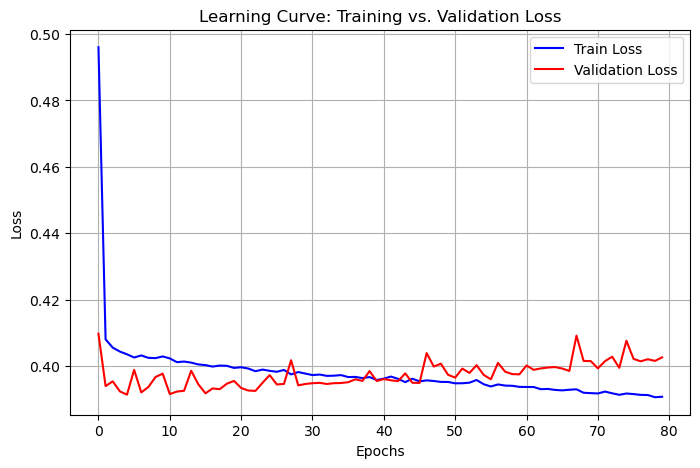

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - f2_metric: 0.8698 - loss: 0.3896
Test F2-Score: 0.8669


In [356]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_transformed.shape[1],)),  
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[f2_metric]  # Custom F2-score metric
    )
    
    return model

# Initialize the model
model = build_model()

# Train the model and store history
history = model.fit(
    X_train_transformed, y_train,
    epochs=80,
    batch_size=32,
    validation_split=0.2,  # 20% of data for validation
    verbose=1
)

import matplotlib.pyplot as plt

# Extract training history
epochs_range = range(len(history.history['loss']))

plot_learning_curve_and_evaluate(history, model, X_test_transformed, y_test)

## Iteration 2

Epoch 1/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - f2_metric: 0.8419 - loss: 0.5385 - val_f2_metric: 0.8652 - val_loss: 0.3962
Epoch 2/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - f2_metric: 0.8573 - loss: 0.4090 - val_f2_metric: 0.8517 - val_loss: 0.3984
Epoch 3/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - f2_metric: 0.8558 - loss: 0.4031 - val_f2_metric: 0.8621 - val_loss: 0.3947
Epoch 4/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - f2_metric: 0.8618 - loss: 0.3996 - val_f2_metric: 0.8503 - val_loss: 0.3941
Epoch 5/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - f2_metric: 0.8660 - loss: 0.3979 - val_f2_metric: 0.8758 - val_loss: 0.3933
Epoch 6/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - f2_metric: 0.8646 - loss: 0.4073 - val_f2_metric: 0.8824 - val_loss: 0.3974
Epoch 7/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - f2_metric: 0.8611 - loss: 0.4102 - val_f2_metric: 0.8471 - val_loss: 0.3971
Epoch 8/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - f2_metric: 0

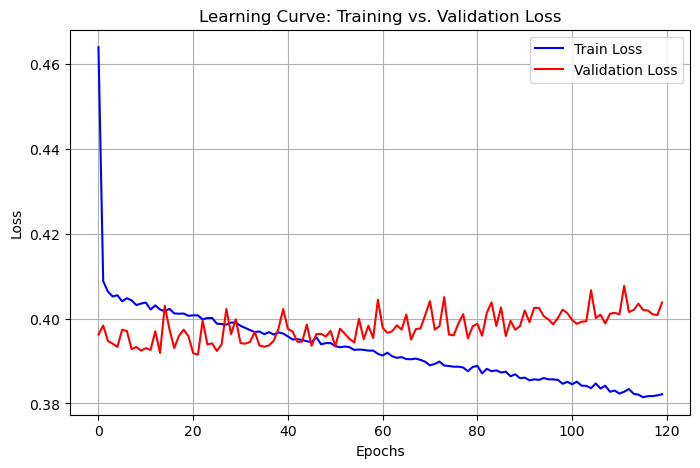

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - f2_metric: 0.8792 - loss: 0.3976
Test F2-Score: 0.8769


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_transformed.shape[1],)),  
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[f2_metric]  # Custom F2-score metric
    )
    
    return model

# Initialize the model
model = build_model()

# Train the model and store history
history = model.fit(
    X_train_transformed, y_train,
    epochs=120,
    batch_size=32,
    validation_split=0.2,  # 20% of data for validation
    verbose=1
)

import matplotlib.pyplot as plt

# Extract training history
epochs_range = range(len(history.history['loss']))

plot_learning_curve_and_evaluate(history, model, X_test_transformed, y_test)

## Iteration 3

Epoch 1/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - f2_metric: 0.8534 - loss: 0.5895 - val_f2_metric: 0.8626 - val_loss: 0.4281
Epoch 2/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - f2_metric: 0.8485 - loss: 0.4531 - val_f2_metric: 0.8758 - val_loss: 0.4021
Epoch 3/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - f2_metric: 0.8617 - loss: 0.4284 - val_f2_metric: 0.8350 - val_loss: 0.4046
Epoch 4/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - f2_metric: 0.8513 - loss: 0.4293 - val_f2_metric: 0.8772 - val_loss: 0.3937
Epoch 5/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - f2_metric: 0.8583 - loss: 0.4124 - val_f2_metric: 0.8734 - val_loss: 0.3973
Epoch 6/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - f2_metric: 0.8562 - loss: 0.4173 - val_f2_metric: 0.8730 - val_loss: 0.3925
Epoch 7/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - f2_metric: 0.8625 - loss: 0.4101 - val_f2_metric: 0.8750 - val_loss: 0.3968
Epoch 8/120
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - f2_metric: 0

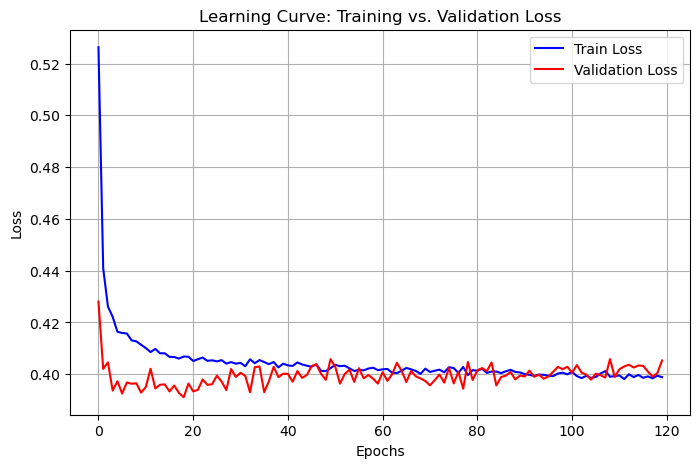

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - f2_metric: 0.8786 - loss: 0.3980
Test F2-Score: 0.8759


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train_transformed.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[f2_metric]  # Custom F2-score metric
    )
    
    return model

# Initialize the model
model = build_model()

# Train the model and store history
history = model.fit(
    X_train_transformed, y_train,
    epochs=120,
    batch_size=32,
    validation_split=0.2,  # 20% of data for validation
    verbose=1
)

import matplotlib.pyplot as plt

# Extract training history
epochs_range = range(len(history.history['loss']))

plot_learning_curve_and_evaluate(history, model, X_test_transformed, y_test)

## Iteration 4

Epoch 1/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - f2_metric: 0.8304 - loss: 0.5574 - val_f2_metric: 0.8592 - val_loss: 0.4029
Epoch 2/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - f2_metric: 0.8526 - loss: 0.4417 - val_f2_metric: 0.8695 - val_loss: 0.3944
Epoch 3/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - f2_metric: 0.8578 - loss: 0.4197 - val_f2_metric: 0.8741 - val_loss: 0.3935
Epoch 4/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - f2_metric: 0.8572 - loss: 0.4235 - val_f2_metric: 0.8564 - val_loss: 0.3942
Epoch 5/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - f2_metric: 0.8606 - loss: 0.4107 - val_f2_metric: 0.8830 - val_loss: 0.3933
Epoch 6/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - f2_metric: 0.8572 - loss: 0.4194 - val_f2_metric: 0.8666 - val_loss: 0.3916
Epoch 7/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - f2_metric: 0.8576 - loss: 0.4160 - val_f2_metric: 0.8526 - val_loss: 0.3965
Epoch 8/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - f2_metric: 0

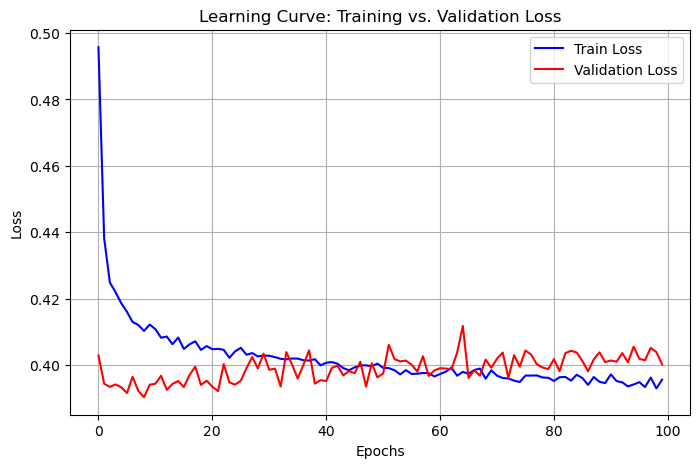

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - f2_metric: 0.8614 - loss: 0.3881
Test F2-Score: 0.8577


In [358]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_transformed.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[f2_metric]  # Custom F2-score metric
    )
    
    return model

# Initialize the model
model = build_model()

# Train the model and store history
history = model.fit(
    X_train_transformed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # 20% of data for validation
    verbose=1
)

import matplotlib.pyplot as plt

# Extract training history
epochs_range = range(len(history.history['loss']))

plot_learning_curve_and_evaluate(history, model, X_test_transformed, y_test)

Epoch 1/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - f2_metric: 0.8189 - loss: 0.5388 - val_f2_metric: 0.8810 - val_loss: 0.4029
Epoch 2/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - f2_metric: 0.8613 - loss: 0.4341 - val_f2_metric: 0.8732 - val_loss: 0.3958
Epoch 3/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - f2_metric: 0.8589 - loss: 0.4232 - val_f2_metric: 0.8669 - val_loss: 0.4105
Epoch 4/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - f2_metric: 0.8654 - loss: 0.4195 - val_f2_metric: 0.8646 - val_loss: 0.4000
Epoch 5/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - f2_metric: 0.8640 - loss: 0.4092 - val_f2_metric: 0.8822 - val_loss: 0.3989
Epoch 6/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - f2_metric: 0.8573 - loss: 0.4121 - val_f2_metric: 0.8722 - val_loss: 0.3929
Epoch 7/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - f2_metric: 0.8610 - loss: 0.4105 - val_f2_metric: 0.8642 - val_loss: 0.3920
Epoch 8/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - f2_metric: 0

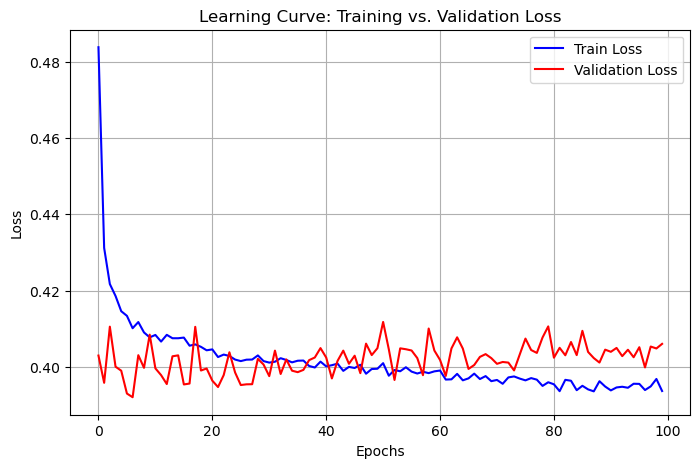

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - f2_metric: 0.8681 - loss: 0.3905
Test F2-Score: 0.8610


In [359]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_transformed.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[f2_metric]  # Custom F2-score metric
    )
    
    return model

# Initialize the model
model = build_model()

# Train the model and store history
history = model.fit(
    X_train_transformed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # 20% of data for validation
    verbose=1
)

import matplotlib.pyplot as plt

# Extract training history
epochs_range = range(len(history.history['loss']))

plot_learning_curve_and_evaluate(history, model, X_test_transformed, y_test)

## Iteration 4

Epoch 1/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - f2_metric: 0.8367 - loss: 0.5367 - val_f2_metric: 0.8787 - val_loss: 0.4009
Epoch 2/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - f2_metric: 0.8589 - loss: 0.4248 - val_f2_metric: 0.8890 - val_loss: 0.3978
Epoch 3/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - f2_metric: 0.8653 - loss: 0.4142 - val_f2_metric: 0.8719 - val_loss: 0.3937
Epoch 4/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - f2_metric: 0.8604 - loss: 0.4147 - val_f2_metric: 0.8869 - val_loss: 0.3964
Epoch 5/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - f2_metric: 0.8644 - loss: 0.4131 - val_f2_metric: 0.8376 - val_loss: 0.3990
Epoch 6/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - f2_metric: 0.8549 - loss: 0.4151 - val_f2_metric: 0.8684 - val_loss: 0.3928
Epoch 7/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - f2_metric: 0.8548 - loss: 0.4115 - val_f2_metric: 0.8605 - val_loss: 0.3925
Epoch 8/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - f2_metric: 0.8562 - 

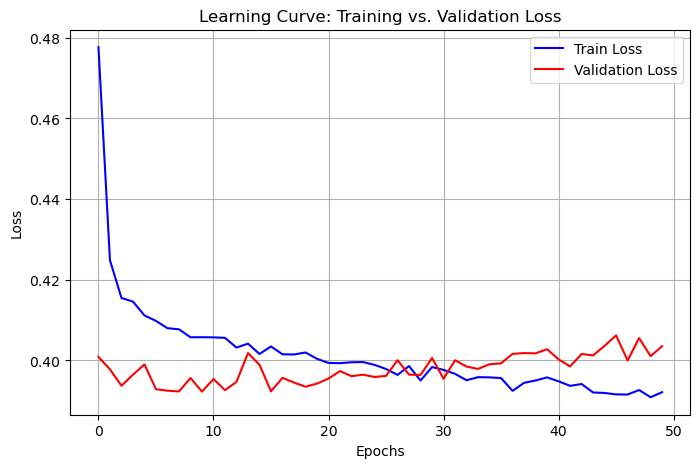

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - f2_metric: 0.8583 - loss: 0.3868
Test F2-Score: 0.8552


In [363]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_transformed.shape[1],)),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[f2_metric]  # Custom F2-score metric
    )
    
    return model

# Initialize the model
model = build_model()

# Train the model and store history
history = model.fit(
    X_train_transformed, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # 20% of data for validation
    verbose=1
)

import matplotlib.pyplot as plt

# Extract training history
epochs_range = range(len(history.history['loss']))

plot_learning_curve_and_evaluate(history, model, X_test_transformed, y_test)

## Itertaion 5 

Epoch 1/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - f2_metric: 0.8042 - loss: 0.5342 - val_f2_metric: 0.8586 - val_loss: 0.4051
Epoch 2/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - f2_metric: 0.8533 - loss: 0.4345 - val_f2_metric: 0.8643 - val_loss: 0.3967
Epoch 3/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - f2_metric: 0.8615 - loss: 0.4200 - val_f2_metric: 0.8786 - val_loss: 0.3956
Epoch 4/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - f2_metric: 0.8617 - loss: 0.4203 - val_f2_metric: 0.8533 - val_loss: 0.3917
Epoch 5/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - f2_metric: 0.8603 - loss: 0.4069 - val_f2_metric: 0.8502 - val_loss: 0.3933
Epoch 6/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - f2_metric: 0.8660 - loss: 0.4016 - val_f2_metric: 0.8660 - val_loss: 0.3916
Epoch 7/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - f2_metric: 0.8604 - loss: 0.4101 - val_f2_metric: 0.8582 - val_loss: 0.3945
Epoch 8/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - f2_metric: 0.8664 - 

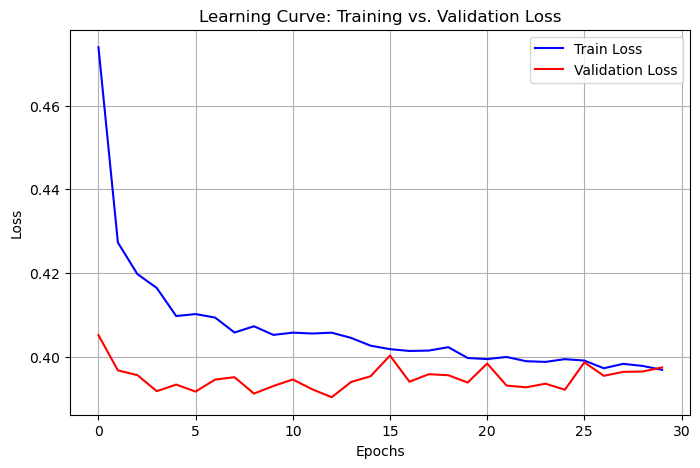

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - f2_metric: 0.8766 - loss: 0.3865
Test F2-Score: 0.8714


In [366]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_transformed.shape[1],)),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[f2_metric]  # Custom F2-score metric
    )
    
    return model

# Initialize the model
model = build_model()

# Train the model and store history
history = model.fit(
    X_train_transformed, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,  # 20% of data for validation
    verbose=1
)

import matplotlib.pyplot as plt

# Extract training history
epochs_range = range(len(history.history['loss']))

plot_learning_curve_and_evaluate(history, model, X_test_transformed, y_test)